# Распознавание эмоций

Задача проекта - улучшить опыт от посещения музеев, городов или новых мест с помощью информационных технологий.
Цель - сделать посещение людьми музеев, городов или новых мест интересным, информативным и комфортным.

## Предлагаемое решение

Реализуем систему распознавания эмоций, которую можно будет использовать для автоматического определения
получаемых людьми эмоций от просмотра, например, музейных экспонатов и т. п. Затем можно будет предлагать
людям для посещения на выбор места, вызывающие интересующие их эмоции. Либо подбирать наиболее
интересующие людей экспонаты и т. п.

[Ссылка на Kaggle](https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data)

In [273]:
import pandas as pd
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F

In [274]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [275]:
df['label'].unique()

array(['Surprise', 'Sad', 'Ahegao', 'Happy', 'Neutral', 'Angry'],
      dtype=object)

In [276]:
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

dataset = ImageFolder('dataset', transform=data_transforms)

img, label = dataset[0]

print(img.shape, label)

torch.Size([3, 32, 32]) 0


Эмоция: Ahegao


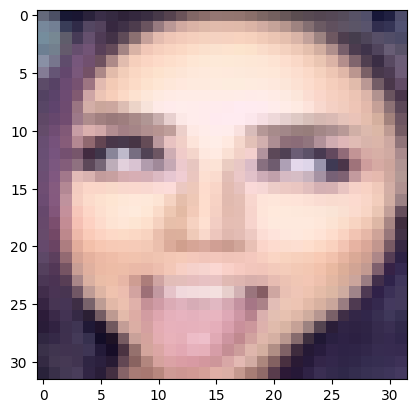

In [277]:
img, label = dataset[0]
print(f"Эмоция: {dataset.classes[label]}")
plt.imshow(img.permute(1,2,0))

In [278]:
batch_size = 256
val_size = 1000
train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 14453
Length of Validation Data : 1000


In [279]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=10, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=10, pin_memory=True)

In [280]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(8192, 256),
            nn.ReLU(),
            nn.Linear(256,6),
        )
    
    def forward(self, xb):
        return self.layers(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {} train loss: {:.4f}, val loss: {:.4f}, val acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [281]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [282]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [283]:
def fit(epochs, lr, model, train_loader, val_loader, optimizer_class):
    history = []
    optimizer = optimizer_class(model.parameters(), lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [284]:
lr = 0.001
optimizer = torch.optim.Adam
num_epochs = 5

In [285]:
history = fit(num_epochs, lr, Model(), train_dl, val_dl, optimizer)
history

Epoch 0 train loss: 1.5976, val loss: 1.4969, val acc: 0.3181
Epoch 1 train loss: 1.3818, val loss: 1.2808, val acc: 0.4834
Epoch 2 train loss: 1.1481, val loss: 1.1483, val acc: 0.5280
Epoch 3 train loss: 0.9962, val loss: 0.9960, val acc: 0.5988
Epoch 4 train loss: 0.9154, val loss: 0.9445, val acc: 0.6307


[{'val_loss': 1.496891975402832,
  'val_acc': 0.31813526153564453,
  'train_loss': 1.5976319313049316},
 {'val_loss': 1.2808239459991455,
  'val_acc': 0.4834144413471222,
  'train_loss': 1.3817853927612305},
 {'val_loss': 1.1483070850372314,
  'val_acc': 0.5279681086540222,
  'train_loss': 1.1480634212493896},
 {'val_loss': 0.9959965944290161,
  'val_acc': 0.5987929105758667,
  'train_loss': 0.9961603283882141},
 {'val_loss': 0.9445350170135498,
  'val_acc': 0.6307152509689331,
  'train_loss': 0.9154340028762817}]